In [206]:
# omitir warning
import warnings

warnings.filterwarnings("ignore")

In [207]:
import pandas as pd
import numpy as np

# Definir las capitales de los estados de México con coordenadas aproximadas (latitud, longitud)
capitales_mexico = [
    ("Aguascalientes", 21.8833, -102.2833),
    ("Baja California", 32.6519, -115.4683),
    ("Baja California Sur", 24.1426, -110.3128),
    ("Campeche", 19.8458, -90.5238),
    ("Chiapas", 16.75, -93.1167),
    ("Chihuahua", 28.6353, -106.0889),
    ("Ciudad de México", 19.4326, -99.1332),
    ("Coahuila", 25.438, -100.9786),
    ("Colima", 19.2433, -103.725),
    ("Durango", 24.0277, -104.6532),
    ("Guanajuato", 21.019, -101.2574),
    ("Guerrero", 17.5669, -99.5148),
    ("Hidalgo", 20.125, -98.7333),
    ("Jalisco", 20.6597, -103.3496),
    ("Estado de México", 19.3574, -99.6307),
    ("Michoacán", 19.7036, -101.19),
    ("Morelos", 18.9186, -99.234),
    ("Nayarit", 21.508, -104.895),
    ("Nuevo León", 25.6667, -100.3167),
    ("Oaxaca", 17.0833, -96.75),
    ("Puebla", 19.0413, -98.2062),
    ("Querétaro", 20.5931, -100.3928),
    ("Quintana Roo", 18.5, -88.3),
    ("San Luis Potosí", 22.1565, -100.9855),
    ("Sinaloa", 24.8069, -107.3932),
    ("Sonora", 29.0729, -110.9559),
    ("Tabasco", 17.9896, -92.9289),
    ("Tamaulipas", 24.2669, -98.8363),
    ("Tlaxcala", 19.3139, -98.2416),
    ("Veracruz", 19.1738, -96.1342),
    ("Yucatán", 20.9674, -89.5926),
    ("Zacatecas", 22.7709, -102.5833),
]

# Crear un DataFrame con la información de las capitales de los estados de México
capitales_df = pd.DataFrame(capitales_mexico, columns=["Capital", "Latitud", "Longitud"])

# definicion de funcion a la que se le pasa un estado y devuelve su latitud y longitud
def get_lat_lon(estado):
    return capitales_df.query(f"Capital == '{estado}'")[["Latitud", "Longitud"]].values[0]



In [208]:
# calculo de salario promedio para el trabajador
fuente_salario_1_mensual = 15000
horas_salario_1 = 10

fuente_salario_2_mensual = 14000
horas_salario_2 = 8

dias_trabajados = 27

# salario global por horas promedio
salario_hora_1 = fuente_salario_1_mensual / (horas_salario_1 * dias_trabajados)
salario_hora_2 = fuente_salario_2_mensual / (horas_salario_2 * dias_trabajados)

salario_final = (salario_hora_1 + salario_hora_2) / 2

round(salario_final, 2)

60.19

In [209]:
## definicion de la funcion de costo
def trip_cost(distanceMeters, duration, tollInfo, salaryPerHour):
    # Distancia y duración
    distance_km = distanceMeters / 1000
    duration_hours = int(duration[:-1]) / 3600  # Convertir duración a horas

    # Calcular costos de peaje
    toll_info = tollInfo
    toll_cost = 0
    if toll_info:
        for toll in toll_info:
            units = float(toll.get("units", 0))
            nanos = float(toll.get("nanos", 0))
            toll_cost += units + nanos / 1e9
    
    # Costos del viaje
    consumptionPerKM = 23.8  # Consumo de combustible por kilómetro
    fuelPricePerLiter = 20.5  # Precio de la gasolina por litro

    seller_cost = duration_hours * salaryPerHour # Salario por hora
    fuel_cost = (distance_km / consumptionPerKM) * fuelPricePerLiter  # Gasto en combustible
    total_cost = seller_cost + fuel_cost + toll_cost

    # Imprimir resultados
    print(f"Distancia: {distance_km:.2f} km")
    print(f"Duración estimada: {duration_hours:.2f} horas")
    print(f"Costo de peajes: ${toll_cost:.2f} MXN")
    print(f"Costo de salario: ${seller_cost:.2f} MXN")
    print(f"Costo de combustible: ${fuel_cost:.2f} MXN")
    print(f"Costo total del viaje: ${total_cost:.2f} MXN")

    return total_cost

In [210]:
# calculo de las distancias entre las capitales de los estados de México
# usando la api de google maps

import requests
import os
import requests

def calculate_trip_cost(api_key, origin_coords, destination_coords, salaryPerHour):
    # Endpoint de la API de Routes
    url = "https://routes.googleapis.com/directions/v2:computeRoutes"
    
    # Estructura de la solicitud
    payload = {
        "origin": {
            "location": {
                "latLng": {
                    "latitude": origin_coords[0],
                    "longitude": origin_coords[1]
                }
            }
        },
        "destination": {
            "location": {
                "latLng": {
                    "latitude": destination_coords[0],
                    "longitude": destination_coords[1]
                }
            }
        },
        "travelMode": "DRIVE",
        "extraComputations": ["TOLLS"]
    }
    
    # Cabeceras de la solicitud
    headers = {
        "Content-Type": "application/json",
        "X-Goog-Api-Key": api_key,
        "X-Goog-FieldMask": "routes.duration,routes.distanceMeters,routes.travelAdvisory.tollInfo,routes.legs.travelAdvisory.tollInfo,routes.legs.polyline"
    }
    
    # Realizar la solicitud
    response = requests.post(url, json=payload, headers=headers)
    
    # Manejar la respuesta
    if response.status_code == 200:
        data = response.json()
        if "routes" in data and len(data["routes"]) > 0:
            route = data["routes"][0]
            
            # calcular el costo del viaje con la funcion trip_cost
            total_cost  =  trip_cost(
                distanceMeters = route["distanceMeters"],
                duration = route["duration"],
                tollInfo = route["travelAdvisory"].get("tollInfo", {}).get("estimatedPrice", []),
                salaryPerHour = salaryPerHour
            )

            return total_cost
        else:
            print("No se encontraron rutas.")
            return None
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None

#load dotenv
from dotenv import load_dotenv
load_dotenv()

# Obtener la clave de la API de Google Maps
api_key = os.getenv("GCP_KEY")

In [ ]:
# # Calcular la matriz de costos de viaje entre las capitales de los estados de México
# cost_matrix = pd.DataFrame(index=[capital[0] for capital in capitales_mexico], columns=[capital[0] for capital in capitales_mexico])

# for origen in capitales_mexico:
#     for destino in capitales_mexico:
#         if origen[0] == destino[0]:
#             cost_matrix.loc[origen[0], destino[0]] = 0
#         else:
#             costo = calculate_trip_cost(api_key, (origen[1], origen[2]), (destino[1], destino[2]), salario_final)
#             cost_matrix.loc[origen[0], destino[0]] = costo

# cost_matrix.to_csv("cost_matrix.csv")

In [212]:
# Definicion de funcion para que dados dos estados se obtenga el geojson de la ruta

import requests
import json
import polyline

def get_route_geojson(api_key, origin_coords, destination_coords):
    """
    Obtiene un GeoJSON que representa la ruta óptima entre dos ciudades.
    
    Args:
        api_key (str): La clave de la API de Google.
        origin_coords (tuple): Coordenadas de la ciudad de origen (latitud, longitud).
        destination_coords (tuple): Coordenadas de la ciudad de destino (latitud, longitud).
        
    Returns:
        dict: Un objeto GeoJSON que representa la ruta.
    """

    
    # Endpoint de la API de Routes
    url = "https://routes.googleapis.com/directions/v2:computeRoutes"
    
    # Estructura de la solicitud
    payload = {
        "origin": {
            "location": {
                "latLng": {
                    "latitude": origin_coords[0],
                    "longitude": origin_coords[1]
                }
            }
        },
        "destination": {
            "location": {
                "latLng": {
                    "latitude": destination_coords[0],
                    "longitude": destination_coords[1]
                }
            }
        },
        "travelMode": "DRIVE"
    }
    
    # Cabeceras de la solicitud
    headers = {
        "Content-Type": "application/json",
        "X-Goog-Api-Key": api_key,
        "X-Goog-FieldMask": "routes.legs.polyline"
    }
    
    # Realizar la solicitud
    response = requests.post(url, json=payload, headers=headers)
    
    if response.status_code == 200:
        data = response.json()
        
        if "routes" in data and len(data["routes"]) > 0:
            # Extraer el polígono codificado de la primera ruta
            polyline_encoded = data["routes"][0]["legs"][0]["polyline"]["encodedPolyline"]
            
            # Decodificar el polígono
            coordinates = polyline.decode(polyline_encoded)
            
            # Convertir coordenadas a formato GeoJSON
            geojson = {
                "type": "Feature",
                "geometry": {
                    "type": "LineString",
                    "coordinates": [[lng, lat] for lat, lng in coordinates]
                },
                "properties": {
                    "origin": origin_coords,
                    "destination": destination_coords
                }
            }
            return geojson
        else:
            raise ValueError("No se encontraron rutas en la respuesta de la API.")
    else:
        raise Exception(f"Error en la solicitud: {response.status_code} - {response.text}")


In [213]:
# Definicion de funcion para graficar rutas sobre el mapa de México
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import json

def plot_geojson_on_mexico(geojson_route):
    """
    Plotea una línea desde un archivo GeoJSON sobre el mapa de México.

    Parameters:
    shapefile_mexico (str): Ruta al shapefile de México.
    geojson_file (str): Ruta al archivo GeoJSON que contiene la línea.
    """
    # ruta al shapefile de México
    shapefile_mexico = "mexican-states-master/mexican-states.shp"

    # Leer el shapefile de México
    mexico = gpd.read_file(shapefile_mexico)


    # Crear la geometría a partir del GeoJSON
    line = LineString(geojson_route["geometry"]["coordinates"])

    # Crear un GeoDataFrame para manejar la línea
    gdf = gpd.GeoDataFrame([{"geometry": line}], crs="EPSG:4326")  # CRS: Sistema de coordenadas

    # Ploteo
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plotea el mapa de México como base
    mexico.plot(ax=ax, color='lightgray', edgecolor='black')  # Mapa base

    # Plotea la línea en el mapa
    gdf.plot(ax=ax, color='red', linewidth=2)  # Línea en el mapa

    # obtener la primer coordenada de la línea
    start_point, end_point = line.coords[0], line.coords[-1]

    # Plotea los puntos de inicio y fin
    ax.plot(start_point[0], start_point[1], marker='o', color='blue', markersize=5)
    ax.plot(end_point[0], end_point[1], marker='o', color='blue', markersize=5)

    # Ajustar la extensión del mapa para que siempre muestre todo México
    ax.set_xlim(mexico.total_bounds[0], mexico.total_bounds[2])  # Límite oeste-este
    ax.set_ylim(mexico.total_bounds[1], mexico.total_bounds[3])  # Límite sur-norte

    # Títulos y etiquetas
    ax.set_title("Línea trazada desde GeoJSON sobre el mapa completo de México")
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")

    # Mostrar el mapa
    plt.show()


In [214]:

# definicion de funcion para obtener la ruta global basado en una lista de estados
def get_global_route(states):
    global_route = []
    # print("[")
    for estado_origen, estado_destino in zip(states[:-1], states[1:]):
        # obtener las coordenadas de los estados
        origen_coords = get_lat_lon(estado_origen)
        destino_coords = get_lat_lon(estado_destino)

        # obtener el geojson de la ruta
        geojson_route = get_route_geojson(api_key, origen_coords, destino_coords)

        # invertir cordenadas de origen_cords
        origen_coords = (origen_coords[1], origen_coords[0])

        # guardar la ruta en la lista global
        global_route.append((estado_origen, origen_coords, geojson_route))

        # imprimir progreso
        print(f"Ruta de {estado_origen} a {estado_destino} obtenida.")

        elemento1 = global_route[-1][0]
        elemento2 = global_route[-1][1]
        #print first 5 coordinates
        elemento3 = global_route[-1][2]['geometry']['coordinates'][:5]

        # print(f"[ {elemento1}, {elemento2}, {str(elemento3)[:-1]}...] ],")
        
    # Aniadir el ultimo estado
    estado_origen = states[-1]
    estado_destino = states[-1]

    # obtener las coordenadas de los estados
    origen_coords = get_lat_lon(estado_origen)
    destino_coords = get_lat_lon(estado_destino)

    # sumar 0.0001 al destino
    destino_coords = (destino_coords[0] + 0.0001, destino_coords[1] + 0.0001)

    # obtener el geojson de la ruta
    geojson_route = get_route_geojson(api_key, origen_coords, destino_coords)

    # invertir cordenadas de origen_cords
    origen_coords = (origen_coords[1], origen_coords[0])

    # guardar la ruta en la lista global
    global_route.append((estado_origen, origen_coords, geojson_route))

    # imprimir progreso
    print(f"Ruta de {estado_origen} a {estado_destino} obtenida.")

    return global_route



In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point

def plot_geojson_on_mexico(state_geojson_list):
    """
    Plotea puntos y líneas de una lista de GeoJSONs sobre el mapa de México.

    Parameters:
    state_geojson_list (list): Lista de tuplas en el formato:
        [(nombre_estado, (lat, lon), geojson_ruta), ...]
    """
    # Ruta al shapefile de México
    shapefile_mexico = "mexican-states-master/mexican-states.shp"

    # Leer el shapefile de México
    mexico = gpd.read_file(shapefile_mexico)

    # Crear figura y ejes para el plot
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plotea el mapa base de México
    mexico.plot(ax=ax, color='lightgray', edgecolor='black')

    # Iterar por cada estado en la lista
    for i, (nombre_estado, coord, geojson_route) in enumerate(state_geojson_list):
        # Extraer la línea desde el GeoJSON
        line = LineString(geojson_route["geometry"]["coordinates"])

        # Crear un GeoDataFrame para la línea
        gdf_line = gpd.GeoDataFrame([{"geometry": line}], crs="EPSG:4326")

        # Plotea la línea
        gdf_line.plot(ax=ax, color='red', linewidth=2)

        # Extraer la coordenada del punto del estado
        state_point = Point(coord)

        # Plotea el punto del estado
        ax.plot(state_point.x, state_point.y, marker='o', color='blue', markersize=8)

        # Etiqueta con el nombre del estado
        ax.text(state_point.x, state_point.y, nombre_estado, fontsize=9, ha='right', color='black')

        # Si no es el último, conecta con la siguiente coordenada
        if i < len(state_geojson_list) - 1:
            next_point = Point(state_geojson_list[i + 1][1])
            connecting_line = LineString([state_point, next_point])
            gdf_connection = gpd.GeoDataFrame([{"geometry": connecting_line}], crs="EPSG:4326")
            gdf_connection.plot(ax=ax, color='orange', linestyle='dashed', linewidth=1)

        # Avisar en qué estado va
        print(f"Ruta de {nombre_estado} ploteada.")

    # Ajustar la extensión del mapa
    ax.set_xlim(mexico.total_bounds[0], mexico.total_bounds[2])  # Límite oeste-este
    ax.set_ylim(mexico.total_bounds[1], mexico.total_bounds[3])  # Límite sur-norte

    # Configuración de títulos y etiquetas
    ax.set_title("Ruta Global sobre el Mapa de México")
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")

    # check if the folder exists
    if not os.path.exists("images"):
        os.makedirs("images")

    # Guardar la imagen con minuto y segundo
    import time
    timestr = time.strftime("%Y%m%d-%H%M%S")
    plt.savefig(f"images/ruta_global_{timestr}.png")

    



In [216]:
# Definicion de grafico de ruta dada una lista de estados
def plot_route(states):
    # obtener la ruta global
    global_route = get_global_route(states)

    # graficar la ruta global
    plot_geojson_on_mexico(global_route)

Ruta de Campeche a Quintana Roo obtenida.
Ruta de Quintana Roo a Chihuahua obtenida.
Ruta de Chihuahua a Chihuahua obtenida.
Ruta de Campeche ploteada.
Ruta de Quintana Roo ploteada.
Ruta de Chihuahua ploteada.


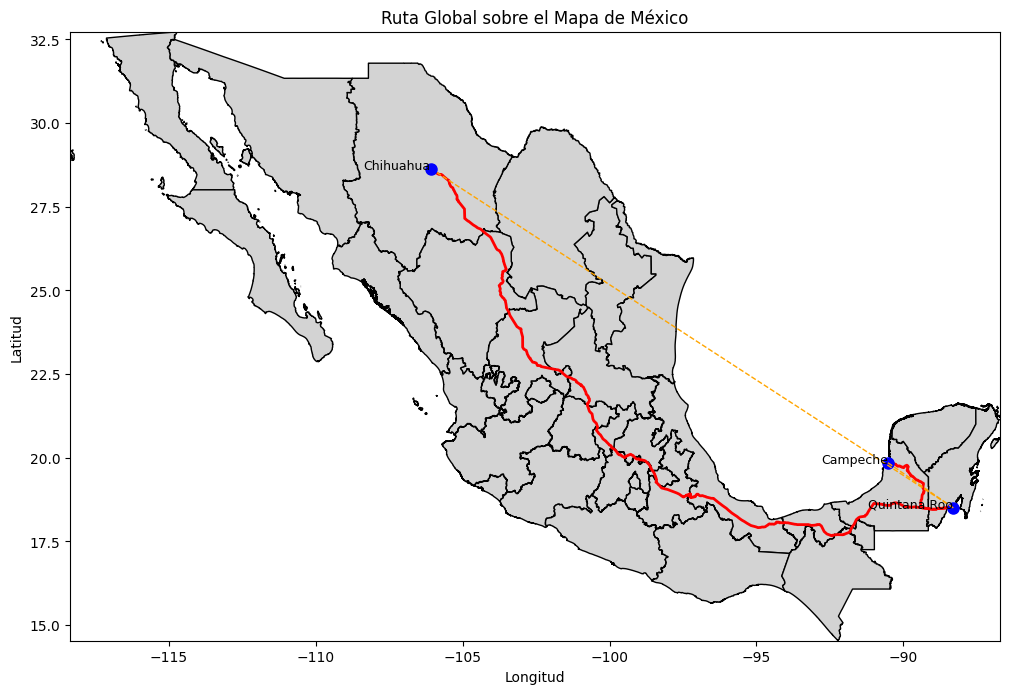

In [217]:
mejor_ruta = ['Campeche', 'Quintana Roo', 'Chihuahua']

plot_route(mejor_ruta)

## Algoritmo ACO

Iteración 1/100, Mejor costo: 34350.85474712108
Iteración 2/100, Mejor costo: 33684.59238250856
Iteración 3/100, Mejor costo: 31693.089905505414
Iteración 4/100, Mejor costo: 30626.340716447077
Iteración 5/100, Mejor costo: 30626.340716447077
Iteración 6/100, Mejor costo: 30626.340716447077
Iteración 7/100, Mejor costo: 30626.340716447077
Iteración 8/100, Mejor costo: 30626.340716447077
Iteración 9/100, Mejor costo: 30626.340716447077
Iteración 10/100, Mejor costo: 30626.340716447077
Iteración 11/100, Mejor costo: 30626.340716447077
Iteración 12/100, Mejor costo: 30626.340716447077
Iteración 13/100, Mejor costo: 30626.340716447077
Iteración 14/100, Mejor costo: 30253.408431718362
Iteración 15/100, Mejor costo: 30253.408431718362
Iteración 16/100, Mejor costo: 30253.408431718362
Iteración 17/100, Mejor costo: 30253.408431718362
Iteración 18/100, Mejor costo: 30253.408431718362
Iteración 19/100, Mejor costo: 30253.408431718362
Iteración 20/100, Mejor costo: 28709.826290330944
Iteración 2

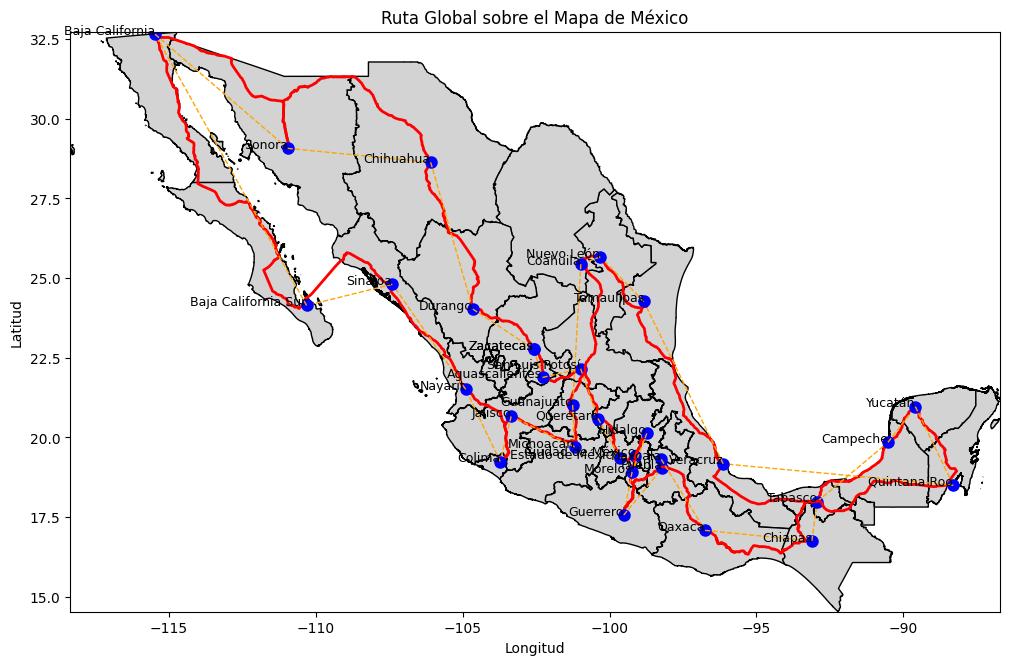

In [223]:
import random
import matplotlib.pyplot as plt

# Parámetros para el algoritmo ACO
NUM_HORMIGAS = 30
ITERACIONES = 100
ALFA = 1.0  # Importancia de la feromona
BETA = 5.0  # Importancia de la heurística (1 / distancia)
EVAPORACION = 0.5  # Tasa de evaporación de feromonas
Q = 100  # Intensidad de feromonas depositadas

# import cost matrix from csv
costos_df = pd.read_csv("cost_matrix.csv", index_col=0)

costos = costos_df.values  # Convertir a una matriz NumPy
ciudades = list(costos_df.index)

# Inicializar matriz de feromonas
num_ciudades = len(ciudades)
feromonas = np.ones((num_ciudades, num_ciudades))

def calcular_probabilidades(ciudad_actual, no_visitadas, feromonas, heuristica, alfa, beta):
    probabilidades = []
    for ciudad in no_visitadas:
        feromona = feromonas[ciudad_actual, ciudad] ** alfa
        heuristic = heuristica[ciudad_actual, ciudad] ** beta
        probabilidades.append(feromona * heuristic)
    suma_probabilidades = sum(probabilidades)
    return [p / suma_probabilidades for p in probabilidades]

def aco(costos, num_hormigas, iteraciones, alfa, beta, evaporacion, q):
    num_ciudades = costos.shape[0]
    heuristica = 1 / (costos + np.eye(num_ciudades) * 1e9)  # Inversa de distancia
    feromonas = np.ones((num_ciudades, num_ciudades))

    mejor_ruta = None
    mejor_costo = float('inf')

    for iteracion in range(iteraciones):
        rutas = []
        costos_rutas = []

        for _ in range(num_hormigas):
            ruta = [random.randint(0, num_ciudades - 1)]
            while len(ruta) < num_ciudades:
                ciudad_actual = ruta[-1]
                no_visitadas = [ciudad for ciudad in range(num_ciudades) if ciudad not in ruta]
                probabilidades = calcular_probabilidades(ciudad_actual, no_visitadas, feromonas, heuristica, alfa, beta)
                siguiente_ciudad = random.choices(no_visitadas, weights=probabilidades)[0]
                ruta.append(siguiente_ciudad)

            ruta.append(ruta[0])  # Volver a la ciudad inicial
            rutas.append(ruta)

            costo_ruta = sum(costos[ruta[i], ruta[i + 1]] for i in range(len(ruta) - 1))
            costos_rutas.append(costo_ruta)

            if costo_ruta < mejor_costo:
                mejor_costo = costo_ruta
                mejor_ruta = ruta

        # Actualización de feromonas
        feromonas *= (1 - evaporacion)
        for ruta, costo_ruta in zip(rutas, costos_rutas):
            for i in range(len(ruta) - 1):
                feromonas[ruta[i], ruta[i + 1]] += q / costo_ruta

        print(f"Iteración {iteracion + 1}/{iteraciones}, Mejor costo: {mejor_costo}")

    return mejor_ruta, mejor_costo

# Ejecutar el algoritmo ACO
mejor_ruta, mejor_costo = aco(costos, NUM_HORMIGAS, ITERACIONES, ALFA, BETA, EVAPORACION, Q)

# Convertir la ruta a nombres de ciudades
mejor_ruta_ciudades = [ciudades[i] for i in mejor_ruta]

print("Mejor ruta encontrada:", mejor_ruta_ciudades)
print("Costo de la mejor ruta:", mejor_costo)

plot_route(mejor_ruta_ciudades)